<a name="top"><h1> Plane-Sweep Coverage analysis</h1></a>

<h2>Michael Schatz (mschatz@cshl.edu)</h2>
<hr>

In this notebook, we will consider the problem of computing the coverage across a sequence given a set of alignments. The alignments could come from reads aligned to a genome, or the layout of reads within a newly assembled contig. It could also be used to track other non-read features, such as the gene regions or other annotations.
 
For example, given these five read alignments, the goal is to compute the coverage vector below it:

    pos:    1    10    20   30   40   50    60    70    80     90
    r1:     [==========================]
    r2:          [================]
    r3:                 [================================]
    r4:                      [=====================]
    r5:                                     [===================]
    
    cov:    11111222222233333444444333332222333333332222221111111

And here is an example with real data: blue and red lines represent PacBio reads, with the coverage profile above them in black, and green marking the position of maximum coverage:

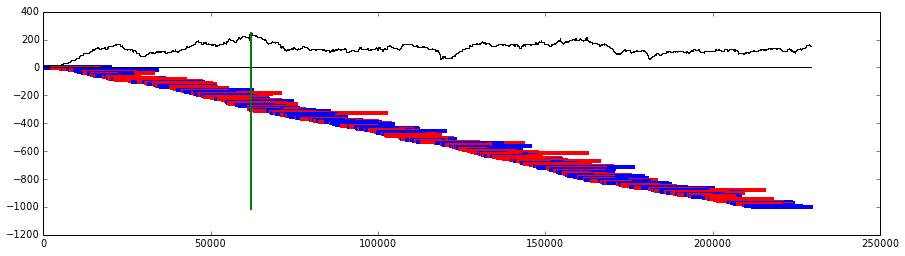


## <center> <a name="result">The main result is with a smart algorithm and smart data structure <br> we can accelerate the basic brute force approaches by **over 300 fold!** </a> </center> ##

Note the algorithms and data structures presented are also generally useful for many other genomic analyses working with intervals. 

<br><br>

<h3>Table of Contents</h3>

** Part I: Brute Force Analysis **

1. [Extract read placements from the Celera Assembler](#extract)
2. [Load the read positions](#load)
3. [Plot the read layouts](#plotlayouts)
4. [Brute-Force coverage analysis](#bruteforce)
5. [Compute the max coverage](#maxcoverge)
6. [Plot the read depth histogram](#plothistogram)
7. [Delta encode the coverage profile](#deltaencode)
8. [Plot the coverage profile](#plotcoverage)

** Part II: Plane Sweep Analysis **

1. [Plane-sweep coverage](#planesweepcoverage)
2. [Checking for errors](#checkerrors)
3. [Refine the plane-sweep update rule](#fixplanesweep)
4. [Heap-based plane-sweep algorithm](#heap)
5. [Max-coverage read ids](#maxreadids) 
6. [Plot the max depth position](#plotmaxdepth) 
7. [Summary](#summary)

<h1> Part I: Brute force analyiss</h1>

<a name="extract">1. Extract the PacBio read placements from the Celera Assembler</a>
---------------------------------------------------------------

To get started, we will first load in the layout of PacBio reads within a contig assembled using the Celera Assemler. In this example, we will be using the read placements from our recent assembly of the [SKBR3 Breast Cancer Cell Line](http://schatzlab.cshl.edu/data/skbr3/). The information of how reads are placed is stored within the "tigStore", which is an on-disk binary database. Because it is a binary database, you cannot read it directly, but instead should use the 'tigStore' command to query or update the database.

These commands will display the unitig layouts:

    $ cd /seq/schatz/mnattest/skbr3/local_assembly/assembly_HLA_Feb17/CA/r1
    
    $ /sonas-hs/schatz/hpc/home/gurtowsk/sources/wgs.svn/Linux-amd64/bin/tigStore -g r1.gkpStore -t r1.tigStore/ 1 -d layout -U | head -20
    unitig 0
    len 0
    cns
    qlt
    data.unitig_coverage_stat  1.000000
    data.unitig_microhet_prob  1.000000
    data.unitig_status         X
    data.unitig_suggest_repeat F
    data.unitig_suggest_unique F
    data.unitig_force_repeat   F
    data.unitig_force_unique   F
    data.contig_status         U
    data.num_frags             2884
    data.num_unitigs           0
    FRG type R ident     18318 container         0 parent     16010 hang   2962   1054 position  19674      0
    FRG type R ident      2248 container     18318 parent     18318 hang    217  -4192 position  15480    218
    FRG type R ident      8536 container      2248 parent      2248 hang    609  -4597 position    827  10881
    FRG type R ident     10602 container      2248 parent      2248 hang    848   -420 position  15057   1067
    FRG type R ident     16010 container         0 parent     18318 hang   1054   2962 position  22636   1089
    FRG type R ident      4611 container     18318 parent     18318 hang   1155  -3014 position   1157  16657
    
This shows the first few reads (fragments, coded as FRG) within unitig 0. Note here we are looking at the "version 1" unitigs, meaning the raw output of the unitigger based on the overlapper before consensus has run. Consequently the unitig length is listed as 0 bp, although there are many reads (2884) reads in this unitig. Also note the unitig consensus and quality strings are also both empty for this reads.


** Finding the longest reads in the assembly** 

For the coverage analysis, the most important values are the last two numbers for the FRG records which encodes the position of the read in the contig. These positions are based on the pair-wise overlap of each read with its immediate neighbors, so the positions may change a little during consensus generation but will show the overall trends. For example, the first read in this unitig is read 18318, and spans from position 19674 to position 0. Because the start position is greater than the end, we know this read has been reverse complemented and really starts at position 0.

For PacBio assemblies, we are often interested in how well the longest reads were assembled. This command will determine which unitig has the longest read in it by annotating each FRG record with the unitig id and the read length as fields 1 and 2:

    $ /sonas-hs/schatz/hpc/home/gurtowsk/sources/wgs.svn/Linux-amd64/bin/tigStore -g r1.gkpStore -t r1.tigStore/ 1 -d layout -U \
    | awk '{if (/^unitig/){tig=$2}else if(/^FRG/){l=$15-$14;if(l<0){l*=-1;} print tig,l,$0}}' \
    | sort -nrk2 | head -10 | column -t

    3   37839  FRG  type  R  ident  5708   container  0  parent  10683  hang  122   20199  position  416262  454101
    3   36519  FRG  type  R  ident  5022   container  0  parent  167    hang  1199  9553   position  402020  365501
    4   35962  FRG  type  R  ident  3652   container  0  parent  10438  hang  199   13564  position  15094   51056
    0   34550  FRG  type  R  ident  11392  container  0  parent  11328  hang  1010  18989  position  182086  216636
    15  34302  FRG  type  R  ident  2622   container  0  parent  5938   hang  6855  7174   position  948470  914168
    15  33695  FRG  type  R  ident  16040  container  0  parent  16226  hang  5741  9003   position  539963  573658
    15  33671  FRG  type  R  ident  5938   container  0  parent  11492  hang  3720  16069  position  941296  907625
    17  33504  FRG  type  R  ident  2341   container  0  parent  9030   hang  192   15632  position  382387  415891
    3   33148  FRG  type  R  ident  8132   container  0  parent  7619   hang  1171  14849  position  162425  129277
    3   32963  FRG  type  R  ident  5377   container  0  parent  14108  hang  1184  17010  position  102322  69359
 
This means that unitig 3 (column 1) has the longest read at 38,839bp which is read 5708. It also has the second longest read with 36,519bp, which is read 5022.


** Report the layout of a selected unitig **

This command will report the read layout for just unitig 3, and just save the readid, start position, and end position to a file:

    $ /sonas-hs/schatz/hpc/home/gurtowsk/sources/wgs.svn/Linux-amd64/bin/tigStore -g r1.gkpStore -t r1.tigStore/ 1 -d layout -u 3 \
      | grep '^FRG' | awk '{print $5,$14,$15}' > ~/readid.start.stop.txt
 
With ``head`` and ``tail`` we can check on the output format

    $ head -3 ~/readid.start.stop.txt
    1 0 19814
    2 799 19947
    3 1844 13454
 
    $ tail -3 ~/readid.start.stop.txt
    1871 973590 965902
    1872 966703 973521
    1873 973632 966946

Now we can load this file and examine the coverage across the contig

<a name="load">2. Load the read position file</a>
------------------------------

The expected file format is: ``readid \t startpos \t endpos``

If ``startpos > endpos``, the read has been reverse complemented
 
It would also be very easy to update the code to process BED, GTF, GFF or even SAM files.

Here is the example readid.start.stop.txt file from the [breast cancer assembly](http://schatzlab.cshl.edu/teaching/exercises/coverage/readid.start.stop.txt).

In [4]:
import matplotlib.pyplot as plt
from collections import deque
import heapq
import time


## Limit the number of reads to load, -1 for unlimited
MAXREADS = -1

## Limit the number of reads to plot
MAX_READS_LAYOUT = 500

## Path to reads file
READFILE = "/Users/mschatz/build/schatzlab/schatzlab.github.io/teaching/exercises/coverage/readid.start.stop.txt"
print "Loading reads from " + READFILE
f = open(READFILE)

## This will have a list of tuples containing (readid, start, end, rc)
## rc is 0 if the read was originally oriented forward, 1 for reverse

reads = []
totallen = 0
readidx = 0

for line in f:
  line = line.rstrip()
  fields = line.split()
  readid  = fields[0]
  start   = int(fields[1])
  end     = int(fields[2])
  rc      = 0

  if (start > end):
    start = int(fields[2])
    end   = int(fields[1])
    rc = 1

  readinfo = (readid, start, end, rc)
  reads.append(readinfo)

  if (end > totallen):
    totallen = end

  readidx += 1
  if (readidx == MAXREADS):
    break

print "Loaded layout information for %d reads" % (len(reads))

for i in xrange(3):
  print "  %d: %s [%d - %d] %d" % (i, reads[i][0], reads[i][1], reads[i][2], reads[i][3])

print "  ..."

for i in xrange(len(reads)-3, len(reads)):
  print "  %d: %s [%d - %d] %d" % (i, reads[i][0], reads[i][1], reads[i][2], reads[i][3])

print "\n\n"


Loading reads from /Users/mschatz/build/schatzlab/schatzlab.github.io/teaching/exercises/coverage/readid.start.stop.txt
Loaded layout information for 1873 reads
  0: read1 [0 - 19814] 0
  1: read2 [799 - 19947] 0
  2: read3 [1844 - 13454] 0
  ...
  1870: read1871 [965902 - 973590] 1
  1871: read1872 [966703 - 973521] 0
  1872: read1873 [966946 - 973632] 1





## <a name="plotlayouts">3. Plot the read layouts</a>

Plotting layout


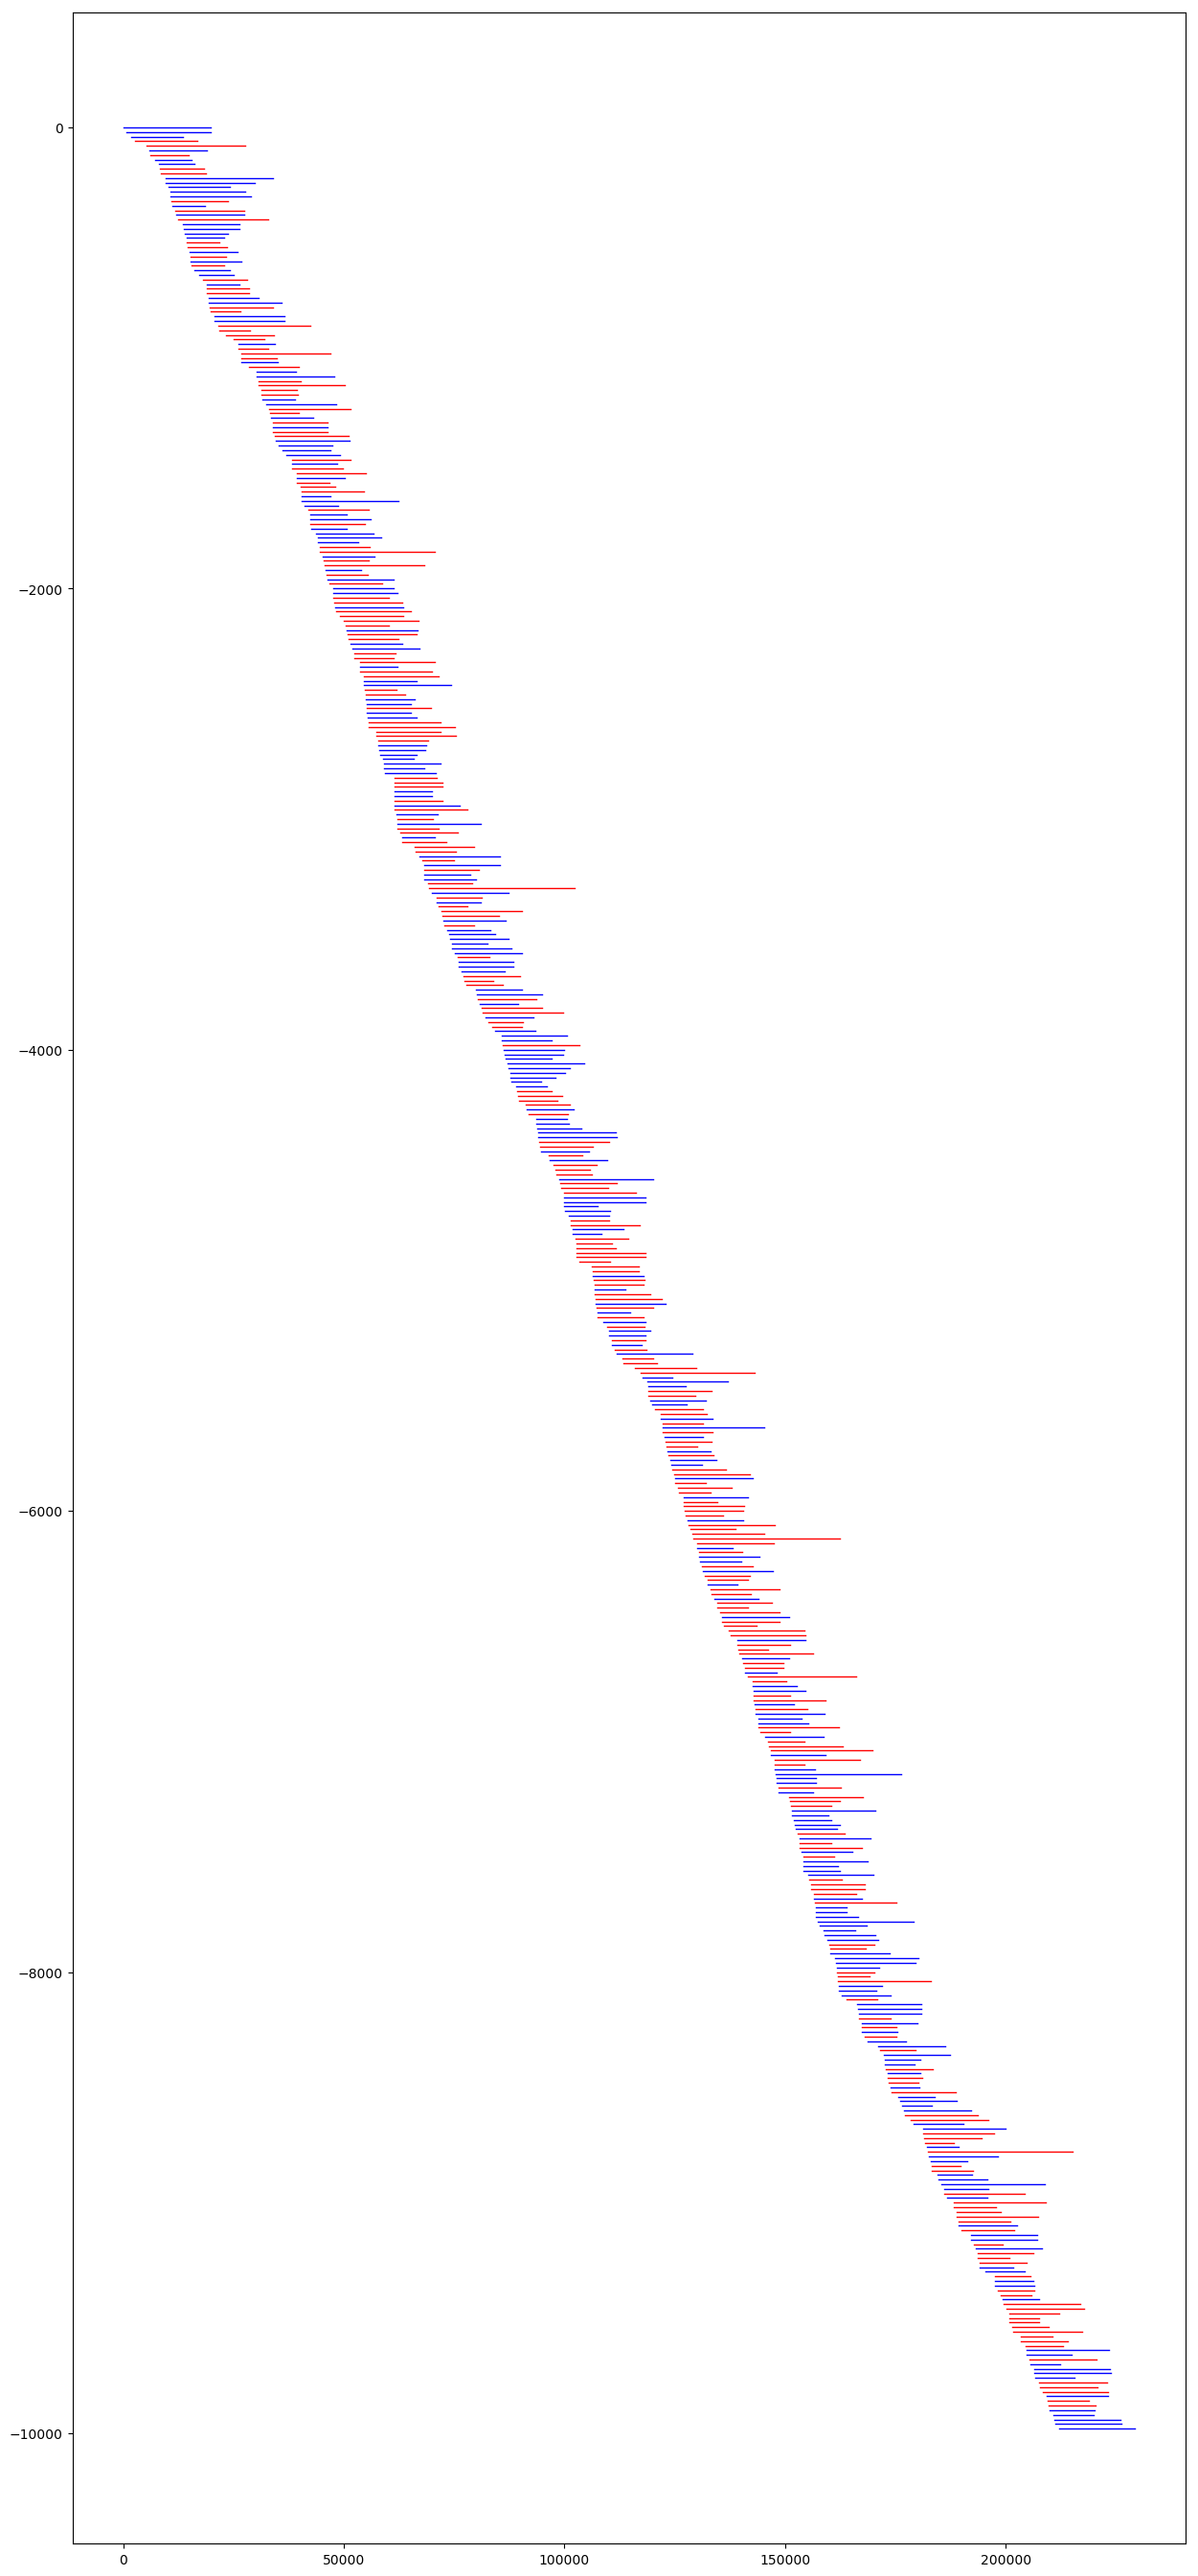

In [12]:
## Note to keep it tractable, we only plot the first MAX_READ_LAYOUT reads

plt.figure(figsize=(15,35), dpi=100)

print "Plotting layout"

## draw the layout of reads
for i in xrange(min(MAX_READS_LAYOUT, len(reads))):
    r = reads[i]
    readid = r[0]
    start  = r[1]
    end    = r[2]
    rc     = r[3]
    color  = "blue"

    if (rc == 1): 
      color = "red"

    plt.plot ([start,end], [-20*i, -20*i], lw=1, color=color)

plt.draw()
plt.show()


<a name="bruteforce">4. Brute force the coverage profile</a>
-----------------------------------

There are several techniques for computing the coverage profile. One basic approach would be to separately compute how many reads span each position in the genome. This would take ``O(G * N)`` time where ``G`` is the length of the genome, and ``N`` is the number of reads. This is easy to see since it requires ``O(1)`` time to detemine if a read spans a given position:

    if ((startpos <= querypos) and (querypos <= endpos)):
      print "This read spans the query position!"

Here we do something slightly smarter which is to initialize the coverage array with all zeros, and then process each read to increment the coverage array at each position in the read. This requires ``O(G + N*L)`` where ``L`` is the average length of the read. Since ``L << G``, this can be a huge advantage.


In [9]:
print "Brute force computing coverage over %d bp" % (totallen)

starttime = time.time()
brutecov = [0] * totallen

for r in reads:
 # print " -- [%d, %d]" % (r[1], r[2])

  for i in xrange(r[1], r[2]):
    brutecov[i] += 1

brutetime = (time.time() - starttime) * 1000.0

print "  Brute force complete in %0.02f ms" % (brutetime)
print brutecov[0:10]

Brute force computing coverage over 973898 bp
  Brute force complete in 4435.00 ms
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


** Notice that it took 4435 ms for this to complete **

<a name="maxcoverage">5. Compute the max coverage</a>
---------------------------

With the coverage profile, it is trivial to compute the max coverage or other simple queries

In [11]:
maxcov = 0
lowcov = 0
LOW_COV_THRESHOLD = 10

for c in brutecov:
  if c > maxcov:
    maxcov = c
  if c <= LOW_COV_THRESHOLD:
    lowcov += 1

print "max cov: %d, there are %d low coverage bases (<= %d depth)" % (maxcov, lowcov, LOW_COV_THRESHOLD)

print "\n\n"


max cov: 49, there are 83209 low coverage bases (<= 10 depth)





<a name="plothistogram">6. Plot the read depth histogram</a>
--------------------------------

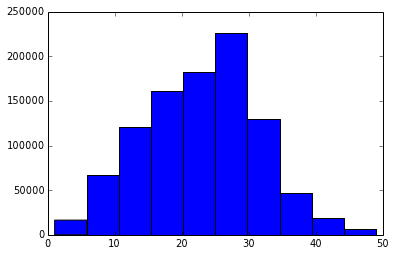

In [12]:
  plt.figure()
  plt.hist(brutecov)
  plt.show()


<a name="deltaencode">7. Delta encode the coverage profile</a>
-----------------------------------

Imagine the coverage profile looks like this:

                 ##                                    #####         ###
                ####                               ############### #########
            ############  #########  ###       ################### ########### 
          ###############################   ###################### #############
    
     cov: 11222234432222112222222221122210001112222333344444333333033444333322110
      
     pos: 00000000001111111111222222222233333333334444444444555555555566666666667
          01234567890123456789012345678901234567890123456789012345678901234567890
    
     
Notice that most consecutive positions have the same depth. This means we can recover exactly this plot if we just record the transitions

                  #                                     #             #  
                 ## #                               #   #    #      # #  #   
             #   ## ##     #          #         #   #   #    #      # #  #   #  
           # #   ## ##   # #        # #  #   #  #   #   #    #      # #  #   # # 
    
     cov: 1 2   34 32   1 2        1 2  10  1  2   3   4    3      3 4  3   2 1 0 
     
     pos: 0 0   00 01   1 1        2 2  33  3  3   4   4    5     55 5  6   6 6 7
          0 2   67 90   4 6        5 7  01  4  7   1   5    0     67 9  2   6 8 0

Here, instead of 70 depth values, we can record just 24 without loss of information!


In [13]:
print "Delta encoding coverage plot"

starttime = time.time()

deltacov = []
curcov = -1
for i in xrange(0, len(brutecov)):
  if brutecov[i] != curcov:
    curcov = brutecov[i]
    delta = (i, curcov)
    deltacov.append(delta)

## Finish up with the last position
deltacov.append((totallen, 0))

print "Delta encoding required only %d steps, saving %0.02f%% of the space in %0.02f ms" % (len(deltacov), (100.0*float(totallen-len(deltacov))/totallen), (time.time()-starttime) * 1000.0)

for i in xrange(3):
  print "  %d: [%d,%d]" % (i, deltacov[i][0], deltacov[i][1])

print "  ..."

for i in xrange(len(deltacov)-3, len(deltacov)):
  print "  %d: [%d,%d]" % (i, deltacov[i][0], deltacov[i][1])

print "\n\n"


Delta encoding coverage plot
Delta encoding required only 3697 steps, saving 99.62% of the space in 151.32 ms
  0: [0,1]
  1: [799,2]
  2: [1844,3]
  ...
  3694: [973770,2]
  3695: [973779,1]
  3696: [973898,0]





<a name="plotcoverage">8. Plot the coverage profile</a>
----------------------------

In theory you could plot the raw coverage profile, but python doesnt like to draw thousands and thousands of little lines. But it does fine for this representation.

Plotting coverage profile


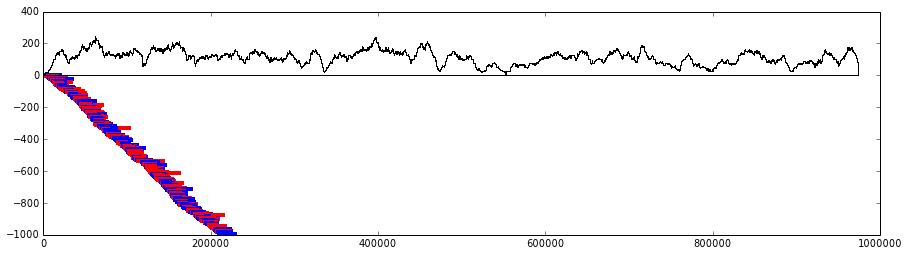

In [35]:
  plt.figure(figsize=(15,4), dpi=100)

  print "Plotting coverage profile"
  
  ## expand the coverage profile by this amount so that it is easier to see
  YSCALE = 5

  ## draw the layout of reads
  for i in xrange(min(MAX_READS_LAYOUT, len(reads))):
    r = reads[i]
    readid = r[0]
    start  = r[1]
    end    = r[2]
    rc     = r[3]
    color  = "blue"

    if (rc == 1): 
      color = "red"

    plt.plot ([start,end], [-2*i, -2*i], lw=4, color=color)

  ## draw the base of the coverage plot
  plt.plot([0, totallen], [0,0], color="black")

  ## draw the coverage plot
  for i in xrange(len(deltacov)-1):
    x1 = deltacov[i][0]
    x2 = deltacov[i+1][0]
    y1  = YSCALE*deltacov[i][1]
    y2  = YSCALE*deltacov[i+1][1]

    ## draw the horizonal line
    plt.plot([x1, x2], [y1, y1], color="black")
    
    ## and now the right vertical to the new coverage level
    plt.plot([x2, x2], [y1, y2], color="black")

  plt.draw()
  plt.show()


<h1> Part II: Plane-sweep analysis</h1>

<a name="planesweepcoverage">1. Plane-sweep coverage</a>
------------------------

Notice the coverage only changes at the beginning or end of a read
so just need to walk from read to read and keep track of depth along the way

Returning to our example again:

    pos:    1    10    20   30   40   50    60    70    80     90
    r1:     [==========================]
    r2:          [================]
    r3:                 [================================]
    r4:                      [=====================]
    r5:                                     [===================]

    cov:    11111222222233333444444333332222333333332222221111111

We can imagine scanning across this from left to right to
keep track of how many reads span each position. This is a widely
used approach in computational geometry called a [plane-sweep](http://en.wikipedia.org/wiki/Sweep_line_algorithm)
algorithm.

The basic technique follows like this:

- Assume layout is in sorted order by start position (or explicitly sort by start position)
- walking from start position to start position
   - check to see if we past any read ends 
   - coverage goes down by one when a read ends
   - coverage goes up by one when new read is encountered
- use a list/deque/heap to track how many reads currently intersect the plane
  - the number of elements in the list corresponds to the current depth

In this example, the plane sweeps like this:

    arrive at 1
     1 (add 50): 50
     
    arrive at 10
    10 (add 40): 40, 50 <- notice insert out of order 
    
    arrive at 20
    20 (add 80): 40, 50, 80
    
    arrive at 30
    30 (add 70): 40, 50, 70, 80 <- out of order again
    
    arrive at 60
    40 (sub 40): 50, 70, 80
    50 (sub 50): 70, 80
    60 (add 90): 70, 80, 90
    
    no more starts, flush the end points
    70 (sub 70): 80, 90
    80 (sub 80): 90
    90 (sub 90): 0


In [34]:
print "Beginning list-based plane sweep over %d reads" % (len(reads))

starttime = time.time()

## record the delta encoded depth using a plane sweep
deltacovplane = []

## use a list to record the end positions of the elements currently in plane
planelist = []

## BEGIN SWEEP 
for r in reads:
  startpos = r[1]
  endpos   = r[2]

  ## clear out any positions from the plane that we have already moved past
  while (len(planelist) > 0):

    if (planelist[0] <= startpos):
      ## the coverage steps down, extract it from the front of the list 
      oldend = planelist.pop(0) 
      deltacovplane.append((oldend, len(planelist)))
    else:
      break

  ## Now insert the current endpos into the correct position into the list
  insertpos = -1
  for i in xrange(len(planelist)):
    if (endpos < planelist[i]):
        insertpos = i
        break

  if (insertpos > 0):
    planelist.insert(insertpos, endpos)
  else:
    planelist.append(endpos)


  ## Finally record that the coverage has increased
  deltacovplane.append((startpos, len(planelist)))


## Flush any remaining end positions
while (len(planelist) > 0):
  oldend = planelist.pop(0) 
  deltacovplane.append((oldend, len(planelist)))


## Report statistics
planelisttime = (time.time() - starttime) * 1000.0
print "Plane sweep found %d steps, saving %0.02f%% of the space in %0.2f ms (%0.02f speedup)!" % (len(deltacovplane), (100.0*float(totallen-len(deltacovplane))/totallen), planelisttime, brutetime/planelisttime)

for i in xrange(3):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "  ..."

for i in xrange(len(deltacovplane)-3, len(deltacovplane)):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "\n\n"


Beginning list-based plane sweep over 1873 reads
Plane sweep found 3746 steps, saving 99.62% of the space in 48.90 ms (90.69 speedup)!
  0: [0,1]
  1: [799,2]
  2: [1844,3]
  ...
  3743: [973770,2]
  3744: [973779,1]
  3745: [973898,0]





<a name="checkerrors">2. Checking for errors</a>
-----------------------

The above implementation is flawed because there may be multiple events (read starts and/or read ends) at the same position. This will leading to multiple entries at the same position, although there should only be one


In [17]:
print "Checking for duplicates:"

lastpos = -1
for i in xrange(len(deltacovplane)):
  if deltacovplane[i][0] == lastpos:
    print "  Found duplicate: %d: [%d,%d] == %d: [%d,%d]" % (i-1, deltacovplane[i-1][0], deltacovplane[i-1][1], i, deltacovplane[i][0], deltacovplane[i][1])
  lastpos = deltacovplane[i][0]

print "\n\n"


Checking for duplicates:
  Found duplicate: 45: [20763,38] == 46: [20763,39]
  Found duplicate: 119: [36471,22] == 120: [36471,21]
  Found duplicate: 158: [46334,37] == 159: [46334,36]
  Found duplicate: 438: [99894,27] == 439: [99894,28]
  Found duplicate: 459: [102773,30] == 460: [102773,31]
  Found duplicate: 527: [118454,16] == 528: [118454,15]
  Found duplicate: 529: [118455,14] == 530: [118455,13]
  Found duplicate: 634: [140597,33] == 635: [140597,32]
  Found duplicate: 650: [142846,29] == 651: [142846,30]
  Found duplicate: 680: [148015,37] == 681: [148015,38]
  Found duplicate: 734: [156928,39] == 735: [156928,40]
  Found duplicate: 736: [157049,39] == 737: [157049,38]
  Found duplicate: 776: [163850,35] == 777: [163850,34]
  Found duplicate: 893: [192138,22] == 894: [192138,23]
  Found duplicate: 925: [200780,26] == 926: [200780,27]
  Found duplicate: 953: [207176,24] == 954: [207176,23]
  Found duplicate: 956: [207608,21] == 957: [207608,20]
  Found duplicate: 1183: [263441,

<a name="fixplanesweep">3. Refine the plane-sweep update rule</a>
--------------------------------------

Lets fix the implementation to check for multiple events at the same position by peeking ahead to check for multiple ends or multiple starts at the exact same position
 
Strictly speaking this may give slightly different results than the brute force coverage profile since this will create an event if a read ends at exactly the same place another begins, whereas the brute force approach will link together those regions because they have the same coverage


In [18]:
print "Beginning correct list-based plane sweep over %d reads" % (len(reads))

starttime = time.time()

## record the delta encoded depth using a plane sweep
deltacovplane = []

## use a list to record the end positions of the elements currently in plane
planelist = []

## BEGIN SWEEP (note change to index based so can peek ahead)
for rr in xrange(len(reads)):
  r = reads[rr]
  startpos = r[1]
  endpos   = r[2]

  ## clear out any positions from the plane that we have already moved past
  while (len(planelist) > 0):

    if (planelist[0] <= startpos):
      ## the coverage steps down, extract it from the front of the list 
      oldend = planelist.pop(0) 

      nextend = -1
      if (len(planelist) > 0):
        nextend = planelist[0]

      ## only record this transition if it is not the same as a start pos
      ## and only if not the same as the next end point
      if ((oldend != startpos) and (oldend != nextend)):
        deltacovplane.append((oldend, len(planelist)))
    else:
      break

  ## Now insert the current endpos into the correct position into the list
  insertpos = -1
  for i in xrange(len(planelist)):
    if (endpos < planelist[i]):
        insertpos = i
        break

  if (insertpos > 0):
    planelist.insert(insertpos, endpos)
  else:
    planelist.append(endpos)


  ## Finally record that the coverage has increased
  ## But make sure the current read does not start at the same position as the next
  if ((rr == len(reads)-1) or (startpos != reads[rr+1][1])):
    deltacovplane.append((startpos, len(planelist)))

  ## if it is at the same place, it will get reported in the next cycle

## Flush any remaining end positions
while (len(planelist) > 0):
  oldend = planelist.pop(0) 
  deltacovplane.append((oldend, len(planelist)))


## Report statistics
planelisttime = (time.time() - starttime) * 1000.0
print "Plane sweep found %d steps, saving %0.02f%% of the space in %0.2f ms (%0.02f speedup)!" % (len(deltacovplane), (100.0*float(totallen-len(deltacovplane))/totallen), planelisttime, brutetime/planelisttime)

for i in xrange(3):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "  ..."

for i in xrange(len(deltacovplane)-3, len(deltacovplane)):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "\n\n"

print "Checking for duplicates in corrected version:"

lastpos = -1
for i in xrange(len(deltacovplane)):
  if deltacovplane[i][0] == lastpos:
    print "  Found duplicate: %d: [%d,%d] == %d: [%d,%d]" % (i-1, deltacovplane[i-1][0], deltacovplane[i-1][1], i, deltacovplane[i][0], deltacovplane[i][1])
  lastpos = deltacovplane[i][0]

print "\n\n"


Beginning correct list-based plane sweep over 1873 reads
Plane sweep found 3698 steps, saving 99.62% of the space in 15.03 ms (295.17 speedup)!
  0: [0,1]
  1: [799,2]
  2: [1844,3]
  ...
  3695: [973770,2]
  3696: [973779,1]
  3697: [973898,0]



Checking for duplicates in corrected version:





## This version is 295 times faster than the basic brute force approach to produce the same output!

<a name="heap">4. Heap-based plane-sweep algorithm</a>
------------------------------------

Lists are bad for maintaining the plane because:

-  removing from the front requires shifting everything over: ``O(N)`` time
-  inserting into the middle (or end) also requires shifting and possibly resizing: ``O(N)``

This can result in a worst case runtime of ``O(N^2)`` because for each read we may need to shift the list by all ``N`` positions. Fortunately, with real datasets the maximum length of the list is bounded by the maximum read depth (D), so will result in an ``O(N*D)`` runtime

If the reads (intervals) were all the same length, we would always append to the end
and remove from the very front. A good data structure for this is called a [deque](http://en.wikipedia.org/wiki/Double-ended_queue)
and enables ``O(1)`` remove-from-front and ``O(1)`` append-to-end operations
                       _________________________________
       appendleft ->  |    |    |    |    |    |    |   | <-- append
       popleft    <-  |____|____|____|____|____|____|___| --> pop


Deques are implemented as a doublely-linked-list, and can be used from the [deque collection API](https://docs.python.org/2/library/collections.html#collections.deque)

    from collections import deque
    d = deque()
    d.append()  <- adds to the end
    d.popleft() <- removes from the front

this estalishes a "queue" for the end positions and accelerates to O(N) runtime!


## Plane-sweep with a heap ##

However, in general, the intervals will not be of uniform length so this will not
be sufficient. The data structure we really want should support very fast (``O(1)``) ability
to find the minimum item of the plane, "fast" ability to remove it, 
and "fast" ability to add a new item to the plane

A good data structure for this is called a <a href="http://en.wikipedia.org/wiki/Heap_(data_structure)">heap</a> (aka min-heap, aka priority queue), and more specifically a [binary heap](http://en.wikipedia.org/wiki/Binary_heap)

Binary heaps are complete binary trees such that the parent is smaller than both of the children. By construction, the height of the tree is completely balanced, except for the bottommost level which may be incomplete. This is made possible because the the relative ordering of the left and right children is arbitrary. (Note it is possible to maintain balanced binary trees in other ways, but wont support constant time look up of minimum values). In a heap it is trival to find the minimum value, since by construction it is always the top of the heap! 

<a href="http://en.wikipedia.org/wiki/Heap_(data_structure)">
![Binary Heap](http://upload.wikimedia.org/wikipedia/commons/6/69/Min-heap.png)</a>





** Removing an element **

Removing the minimum is a bit more compplex and requires ``O(log n)`` steps. The first step is to shift a leaf value into the root position. If that value happens to be smaller than the children, then done. Otherwise, interatively swap it with the smaller of its two children. In the worst case, it will be reswapped down to the botton of the heap again in ``O(log n)`` steps. Note the deletions are always picked from the leaf nodes so the balance of tree will be guaranteed.

Here is a nice tutorial on [removing an element](http://www.algolist.net/Data_structures/Binary_heap/Remove_minimum)


** Inserting into a heap **
   
Adding a new value into a heap is fast: the value is added as the first available leaf node and then repeatedly pushed up the heap if its value is smaller than its parents. In the worst case this could require ``O(log n)`` up-heap operations, but in average can be done in ``O(1)`` time. 

Note if the values to be inserted are in sorted order, the values are easily added in ``O(1) time`

Here is a nice tutorial on [inserting an element](http://www.algolist.net/Data_structures/Binary_heap/Insertion)



** Representing a heap **
We can store a heap by embedding the tree inside of an array so that the children at node ``k`` are indexed at nodes ``2k+1`` and ``2k+2``. This is useful because then we dont have to incure the storage costs of the tree pointers. Up-heap or down-heap operations are a simple matter of swapping elements in the list, and finding the next free leaf is just the first free cell at the end of the list.

For example, the above heap can be represented as

    idx    0   1   2   3   4   5   6   7   8
    val    1   2   3  17  19  36   7  25 100  
    
The next free cell is 9, which is a child of 4 (``2*4+1 = 9``)

In python, these techniques are implemented in the [heapq](https://docs.python.org/2/library/heapq.html) package. This restores us to ``O(N log N)`` worst case runtime. However, the time to maintain the heap is bounded by the size of it, so in practice the runtime will be much faster: ``O(N log D)`` where ``D`` is the maximum depth of coverage. For more genomics project, this is effectively a constant value around ``log(100) = 8``.

In [19]:
print "Beginning heap-based plane sweep over %d reads" % (len(reads))

starttime = time.time()

## record the delta encoded depth using a plane sweep
deltacovplane = []

## use a list to record the end positions of the elements currently in plane
planeheap = []

## BEGIN SWEEP (note change to index based so can peek ahead)
for rr in xrange(len(reads)):
  r = reads[rr]
  startpos = r[1]
  endpos   = r[2]

  ## clear out any positions from the plane that we have already moved past
  while (len(planeheap) > 0):

    if (planeheap[0] <= startpos):
      ## the coverage steps down, extract it from the front of the list 
      ## oldend = planelist.pop(0) 
      oldend = heapq.heappop(planeheap)

      nextend = -1
      if (len(planeheap) > 0):
        nextend = planeheap[0]

      ## only record this transition if it is not the same as a start pos
      ## and only if not the same as the next end point
      if ((oldend != startpos) and (oldend != nextend)):
        deltacovplane.append((oldend, len(planeheap)))
    else:
      break

  ## Now insert the current endpos into the correct position into the list

  ##insertpos = -1
  ##for i in xrange(len(planelist)):
  ##  if (endpos < planelist[i]):
  ##      insertpos = i
  ##      break

  ##if (insertpos > 0):
  ##  planelist.insert(insertpos, endpos)
  ##else:
  ##  planelist.append(endpos)

  heapq.heappush(planeheap, endpos)


  ## Finally record that the coverage has increased
  ## But make sure the current read does not start at the same position as the next
  if ((rr == len(reads)-1) or (startpos != reads[rr+1][1])):
    deltacovplane.append((startpos, len(planeheap)))

  ## if it is at the same place, it will get reported in the next cycle


## Flush any remaining end positions
while (len(planeheap) > 0):
  ##oldend = planelist.pop(0) 
  oldend = heapq.heappop(planeheap)
  deltacovplane.append((oldend, len(planeheap)))



## Report statistics
planeheaptime = (time.time()-starttime) * 1000.0
print "Heap-Plane sweep found %d steps, saving %0.02f%% of the space in %0.02f ms (%0.02f speedup)!" % (len(deltacovplane), (100.0*float(totallen-len(deltacovplane))/totallen), planeheaptime, brutetime/planeheaptime)

for i in xrange(3):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "  ..."

for i in xrange(len(deltacovplane)-3, len(deltacovplane)):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "\n\n"

print "Checking for duplicates in heap-ified version:"

lastpos = -1
for i in xrange(len(deltacovplane)):
  if deltacovplane[i][0] == lastpos:
    print "  Found duplicate: %d: [%d,%d] == %d: [%d,%d]" % (i-1, deltacovplane[i-1][0], deltacovplane[i-1][1], i, deltacovplane[i][0], deltacovplane[i][1])
  lastpos = deltacovplane[i][0]

print "\n\n"


Beginning heap-based plane sweep over 1873 reads
Heap-Plane sweep found 3698 steps, saving 99.62% of the space in 14.26 ms (311.08 speedup)!
  0: [0,1]
  1: [799,2]
  2: [1844,3]
  ...
  3695: [973770,2]
  3696: [973779,1]
  3697: [973898,0]



Checking for duplicates in heap-ified version:





# <a name="awesome"><center>The heap-based plane-sweep algorithm is 311 times faster than the brute force approach!</center><a>

<a name="maxreadids">5. Max-coverage read ids</a>
-------------------------

Now lets use this framework to figure out which reads span the position of max coverage as we are scanning the alignments. The technique is to update the heap to store the read end position as the primary key, but also associate it with the read id. Then whenever we see we have established a new maximum coverage level, we record the ids of the reads in the heap.

In [20]:
print "Beginning heap-based plane sweep over %d reads to search for max reads" % (len(reads))

starttime = time.time()

## record the delta encoded depth using a plane sweep
deltacovplane = []

## use a list to record the end positions of the elements currently in plane
planeheap = []

## use a list to record the ids at max coverage
maxcov = -1
maxcovpos = -1
maxcovreads = []

## BEGIN SWEEP (note change to index based so can peek ahead)
for rr in xrange(len(reads)):
  r = reads[rr]
  readid   = r[0]
  startpos = r[1]
  endpos   = r[2]

  ## clear out any positions from the plane that we have already moved past
  while (len(planeheap) > 0):

    if (planeheap[0][0] <= startpos):
      ## the coverage steps down, extract it from the front of the list 
      oldend = heapq.heappop(planeheap)[0]

      nextend = -1
      if (len(planeheap) > 0):
        nextend = planeheap[0][0]

      ## only record this transition if it is not the same as a start pos
      ## and only if not the same as the next end point
      if ((oldend != startpos) and (oldend != nextend)):
        deltacovplane.append((oldend, len(planeheap)))
    else:
      break

  ## Now insert the current endpos into the correct position into the list
  heapq.heappush(planeheap, (endpos, readid))


  ## Finally record that the coverage has increased
  ## But make sure the current read does not start at the same position as the next
  if ((rr == len(reads)-1) or (startpos != reads[rr+1][1])):
    cov = len(planeheap)
    if (cov > maxcov):
      maxcov = cov
      maxcovpos = startpos
      maxcovreads = []
      for rr in planeheap:
        maxcovreads.append(rr[1])

    deltacovplane.append((startpos, len(planeheap)))


## Flush any remaining end positions
while (len(planeheap) > 0):
  oldend = heapq.heappop(planeheap)[0]
  deltacovplane.append((oldend, len(planeheap)))



## Report statistics
planeheaptime = (time.time()-starttime) * 1000.0
print "Heap-Plane sweep found %d steps, saving %0.02f%% of the space in %0.02f ms (%0.02f speedup)!" % (len(deltacovplane), (100.0*float(totallen-len(deltacovplane))/totallen), planeheaptime, brutetime/planeheaptime)

print "The %d reads at the position of maximum depth (%d) are:" % (maxcov, maxcovpos)
print maxcovreads

print "\n\n"

for i in xrange(3):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "  ..."

for i in xrange(len(deltacovplane)-3, len(deltacovplane)):
  print "  %d: [%d,%d]" % (i, deltacovplane[i][0], deltacovplane[i][1])

print "\n\n"

print "Checking for duplicates in heap-ified version:"

lastpos = -1
for i in xrange(len(deltacovplane)):
  if deltacovplane[i][0] == lastpos:
    print "  Found duplicate: %d: [%d,%d] == %d: [%d,%d]" % (i-1, deltacovplane[i-1][0], deltacovplane[i-1][1], i, deltacovplane[i][0], deltacovplane[i][1])
  lastpos = deltacovplane[i][0]

print "\n\n"


Beginning heap-based plane sweep over 1873 reads to search for max reads
Heap-Plane sweep found 3698 steps, saving 99.62% of the space in 14.36 ms (308.74 speedup)!
The 49 reads at the position of maximum depth (62132) are:
['read118', 'read112', 'read102', 'read113', 'read107', 'read82', 'read129', 'read114', 'read104', 'read105', 'read111', 'read125', 'read124', 'read110', 'read108', 'read135', 'read119', 'read121', 'read126', 'read128', 'read138', 'read146', 'read93', 'read96', 'read137', 'read127', 'read106', 'read148', 'read136', 'read131', 'read140', 'read139', 'read130', 'read117', 'read120', 'read141', 'read122', 'read132', 'read133', 'read134', 'read142', 'read143', 'read144', 'read145', 'read149', 'read147', 'read150', 'read151', 'read152']



  0: [0,1]
  1: [799,2]
  2: [1844,3]
  ...
  3695: [973770,2]
  3696: [973779,1]
  3697: [973898,0]



Checking for duplicates in heap-ified version:





<a name="plotmaxdepth">6. Plot the max depth position</a>
-------------------------------

Plotting max depth




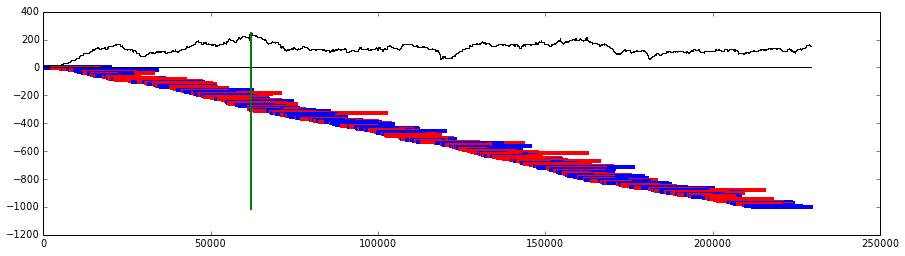

In [33]:
  f = plt.figure(figsize=(15,4), dpi=100)
    
  print "Plotting max depth\n\n"

  lastend = -1
  lastidx = -1
    
  ## draw the layout of reads
  for i in xrange(min(MAX_READS_LAYOUT, len(reads))):
    r = reads[i]
    readid = r[0]
    start  = r[1]
    end    = r[2]
    rc     = r[3]
    color  = "blue"

    if (rc == 1): 
      color = "red"

    plt.plot ([start,end], [-2*i, -2*i], lw=4, color=color)
    lastend = end
    lastidx = i

  ## draw the base of the coverage plot
  plt.plot([0, lastend], [0,0], color="black")

  ## draw the coverage profile
  for i in xrange(len(deltacov)-1):
    x1 = deltacov[i][0]
    x2 = deltacov[i+1][0]
    y1  = YSCALE * deltacov[i][1]
    y2  = YSCALE * deltacov[i+1][1]

    ## draw the horizonal line
    plt.plot([x1, x2], [y1, y1], color="black")
    
    ## and now the right vertical to the new coverage level
    plt.plot([x2, x2], [y1, y2], color="black")
    if (x2 >= lastend):
        break

  ## draw a vertical bar with the max coverage
  plt.plot([maxcovpos, maxcovpos], [YSCALE*maxcov, -(2*lastidx+20)], color="green", lw=2)
  plt.draw()
  plt.show()


<a name="summary">7. Summary</a>
-----------

In this example, the heap-based plane sweep algorithm was 300 to 400 times
faster than the basic brute force approach on my laptop! The advantage
of the heap-based approach over the list based approach will become even 
more significant with deeper coverage as ``log(D)`` and ``D`` become more significant differences.

In the next session we will explore the related question of how to index 
the alignments to be able to quickly determine which reads span a particular location. Plane-sweep algorithms are also widely used to solve many interesting problems in [computational geometry](http://en.wikipedia.org/wiki/Computational_geometry)
